In [1]:
# Handle warnings
import warnings
warnings.filterwarnings('ignore')

# Handling the data
import re
import string
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter

# Data visulization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


# NLP tools
import nltk
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Dropout,Embedding,BatchNormalization,SpatialDropout1D

# Vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Models evaluation
from sklearn.metrics import confusion_matrix

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
data = pd.read_csv(r'Restaurant_Reviews.csv')
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
data.tail()

,Review,Liked
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0
999,"Then, as if I hadn't wasted enough of my life ...",0


In [5]:
data.shape

(1000, 2)

In [6]:
data['Liked'] = data['Liked'].map({0:'Negative',1:'Positive'})

In [7]:
data.describe().T

,count,unique,top,freq
Review,1000,993,#NAME?,4
Liked,1000,2,Positive,500


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [9]:
data.columns

Index(['Review', 'Liked'], dtype='object')

In [10]:
# Auxiliary dictionary in word processing

mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" ,"'ll":"will","'d":"would"}

In [11]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
'not' in stop_words

False

In [12]:
print('Original :',data.Review.iloc[1])
print('processed with not removing negation :',' '.join([word for word in data.Review.iloc[1].split() if word not in stop_words]))

Original : Crust is not good.
processed with not removing negation : Crust not good.


In [13]:
def text_preprocessing(text,lemmatize=False):
    '''input    : the text you want to process.
       output   : the processed text '''

    # Remove html tags
    text = BeautifulSoup(text, 'html.parser')
    text = text.get_text()
    # Lowercasing
    text = text.lower()
    # Removal of special characters, URLs, and mentions
    text = re.sub(r'http\S+|www\S+|https\S+|@[^\s]+', '', text)
    # remove more than one space with one space
    text = re.sub(r'\s+',' ',text)
    # remove more than one dot by one dot
    text = re.sub(r'\.{2,}', '.', text)
    #remove numbers with no space
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Remove punctuation,stopwords and handling the txt with (mapping dictionary) *predefiend above*
    words = [mapping[word] if word in mapping else word for word in words]
    words = [word for word in words if word not in string.punctuation]
    words = [word for word in words if word not in stop_words]

    # optionally lemmatize
    if lemmatize:
        words = [nlp(word)[0].lemma_ for word in words]

    return ' '.join(words)

In [14]:
# Function performance experiment
print('Original :',data.Review.iloc[0])
print()
print('Porcessed text :',text_preprocessing(data.Review.iloc[0],lemmatize=True))

Original : Wow... Loved this place.

Porcessed text : wow love place


In [15]:
data['Processed_text'] = data['Review'].apply(lambda x : text_preprocessing(str(x),lemmatize=True))

In [16]:
data.head(10)

,Review,Liked,Processed_text
0,Wow... Loved this place.,Positive,wow love place
1,Crust is not good.,Negative,crust not good
2,Not tasty and the texture was just nasty.,Negative,not tasty texture nasty
3,Stopped by during the late May bank holiday of...,Positive,stop late may bank holiday rick steve recommen...
4,The selection on the menu was great and so wer...,Positive,selection menu great price
5,Now I am getting angry and I want my damn pho.,Negative,get angry want damn pho
6,Honeslty it didn't taste THAT fresh.),Negative,honeslty not taste fresh
7,The potatoes were like rubber and you could te...,Negative,potato like rubber could tell make ahead time ...
8,The fries were great too.,Positive,fry great
9,A great touch.,Positive,great touch


In [17]:
data.nunique()

,0
Review,993
Liked,2
Processed_text,985


In [18]:
data.duplicated().sum()

6

In [19]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [20]:
def generate_wordcloud(text,bg_color,title ='word cloud'):
    '''
    input : Text ,Back-ground color and Title
    output : Word cloud of most common words with your preferd title and back-ground color
    '''
    wordcloud =WordCloud(background_color=str(bg_color),stopwords=set(stopwords.words('english'))).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(str(title))
    plt.axis("off")
    plt.show()

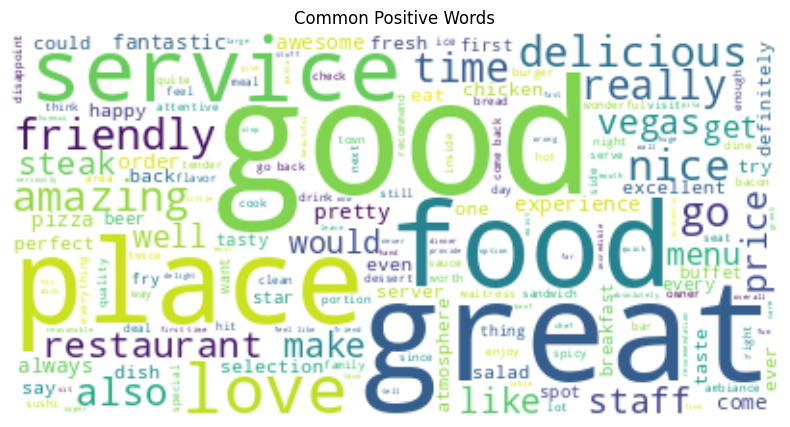

In [21]:
generate_wordcloud(" ".join(data[data['Liked']=='Positive']['Processed_text']),bg_color='white',title='Common Positive Words')

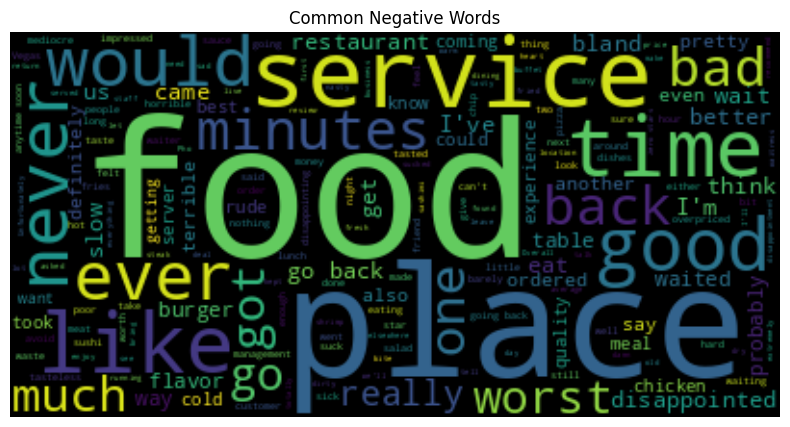

In [22]:
generate_wordcloud(" ".join(data[data['Liked']=='Negative']['Review']),bg_color='black',title='Common Negative Words')

In [23]:
fig = make_subplots(rows=1, cols=2,specs=[[{'type':'xy'}, {'type':'domain'}]])

fig.add_trace(
    go.Bar(
        x=data['Liked'].value_counts().index,
        y= data['Liked'].value_counts().values,
         marker=dict(color=['#6B816C','#91B092']), showlegend=False,
           text=data['Liked'].value_counts().values, textposition='auto', textfont=dict(size=18)
        ),
    row=1,col=1
    )

fig.add_trace(
    go.Pie(
        labels=data['Liked'].value_counts().index,
        values=data['Liked'].value_counts().values,
         marker=dict(colors=['#6B816C','#91B092']), textfont=dict(size=18),
         pull=[0.01,0.01]
        ),
    row=1,col=2
    )





fig.update_layout(title='<b>Distribution of the target<b>',
                 title_font={'size':25},
                 paper_bgcolor='#E0E1CD',
                 plot_bgcolor='#E0E1CD',
                 showlegend=True)

fig.update_yaxes(showgrid=False)
fig.show()


In [24]:
def plot_commmon_words(data,title):

    '''
    input : Your data and title.
    output : plotting the top 20 common words in the input data with title you want to put on the figure.
    '''
    # put all words in one list
    corpus =[]
    for row in data:
        corpus.extend(row.split())
    # get the most common words (top 20)
    most_common_words = Counter(corpus)
    most_common_words = most_common_words.most_common(20)
    # creat the data frame of most common words (top 20)
    tem_df = pd.DataFrame(most_common_words,columns=['word','Repetition'])
    # creat the figure
    fig = px.bar(tem_df, x="Repetition", y="word", orientation='h',
             color='word')

    fig.update_layout(title=f'<b>{title}<b>',
                 title_font={'size':25},
                 paper_bgcolor='#E0E1CD',
                 plot_bgcolor='#E0E1CD',
                 showlegend=True)

    fig.update_yaxes(showgrid=False)
    fig.update_xaxes(showgrid=False)
    fig.show()

In [25]:
plot_commmon_words(data[data['Liked']=='Positive']['Processed_text'],title='Most common words in positive reviews')

In [26]:
plot_commmon_words(data[data['Liked']=='Negative']['Processed_text'],title='Most common words in negative reviews')

In [27]:
plot_commmon_words(data['Processed_text'],title='Most common words in all reviews')

In [28]:
def plot_most_freq_ngrams(text,n,title):
    '''
    input : the text or data,n-grame range and title of the figure.
    output : plotting the most common ngrams as you want
    '''

    #initialize bag of words and fitting the data
    vectorizer = CountVectorizer(ngram_range=(n,n),stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(text)
    # make a summation of all reapeted ngrams
    feature_counts = X.sum(axis=0)
    # get feature name
    feature_names = vectorizer.get_feature_names_out()
    # prepre df and make sorting to get most common ngrams
    df = pd.DataFrame({'Feature': feature_names, 'Count': feature_counts.tolist()[0]})
    df = df.sort_values(by='Count',ascending=False).head(20).reset_index(drop=True)
    # plotting the figure
    fig = px.bar(df, x="Count", y="Feature" ,orientation='h',
             color='Feature')

    fig.update_layout(title=f'<b>{title}<b>',
                 title_font={'size':25},
                 paper_bgcolor='#E0E1CD',
                 plot_bgcolor='#E0E1CD',
                 showlegend=True)

    fig.update_xaxes(showgrid=False)
    fig.show()

In [29]:
plot_most_freq_ngrams(data['Processed_text'],n=1,title='most common unigrams to all data')

In [30]:
plot_most_freq_ngrams(data['Processed_text'],n=2,title='most common bigrams to all data')


In [31]:
plot_most_freq_ngrams(data['Processed_text'],n=3,title='most common trigrams to all data')

In [32]:
plot_most_freq_ngrams(data[data['Liked']=='Positive']['Processed_text'],n=2,title='most common bigrams to positve reviews')

In [33]:
plot_most_freq_ngrams(data[data['Liked']=='Positive']['Processed_text'],n=3,title='most common trigrams to positve reviews')

In [34]:
plot_most_freq_ngrams(data[data['Liked']=='Negative']['Processed_text'],n=2,title='most common bigrams to negative reviews')

In [35]:
plot_most_freq_ngrams(data[data['Liked']=='Negative']['Processed_text'],n=3,title='most common trigrams to negative reviews')

In [36]:
data['words_len'] = data['Review'].apply(lambda x : len(x.split()))
data.head()

,Review,Liked,Processed_text,words_len
0,Wow... Loved this place.,Positive,wow love place,4
1,Crust is not good.,Negative,crust not good,4
2,Not tasty and the texture was just nasty.,Negative,not tasty texture nasty,8
3,Stopped by during the late May bank holiday of...,Positive,stop late may bank holiday rick steve recommen...,15
4,The selection on the menu was great and so wer...,Positive,selection menu great price,12


In [37]:
fig = go.Figure()

fig.add_trace(go.Violin(x=data[data['Liked']=='Positive']['words_len'],line_color='#91B092',y0=0,name='Positive'))
fig.add_trace(go.Violin(x=data[data['Liked']=='Negative']['words_len'],line_color='#6B816C',y0=0,name='Negative'))
fig.update_traces(orientation='h',side='positive',meanline_visible=True)

fig.update_layout(title = "<b> distribution of word counts in positive & negative reviews",
                 titlefont={'size':20},
                 xaxis_zeroline=False,
                 paper_bgcolor='#E0E1CD',
                 plot_bgcolor='#E0E1CD')
fig.update_xaxes(showgrid=False,title='Word length')
fig.update_yaxes(showgrid=False)

fig.show()

In [38]:
data['Review_len'] = data['Review'].apply(lambda x :len(x))
data.head()

,Review,Liked,Processed_text,words_len,Review_len
0,Wow... Loved this place.,Positive,wow love place,4,24
1,Crust is not good.,Negative,crust not good,4,18
2,Not tasty and the texture was just nasty.,Negative,not tasty texture nasty,8,41
3,Stopped by during the late May bank holiday of...,Positive,stop late may bank holiday rick steve recommen...,15,87
4,The selection on the menu was great and so wer...,Positive,selection menu great price,12,59


In [39]:
import plotly.figure_factory as ff

fig = ff.create_distplot(
    [data[data['Liked'] == 'Positive']['Review_len'], data[data['Liked'] == 'Negative']['Review_len']],
    ['Positive', 'Negative'],
    show_hist=True,
    show_rug=False,
)

# Update the colors of both histograms and curves
fig['data'][0].marker.color = '#91B092'  # Positive color for the histogram
fig['data'][1].marker.color = '#6B816C'  # Negative color for the histogram

fig['data'][2].line.color = '#91B092'  # Positive color for the curve
fig['data'][3].line.color = '#6B816C'  # Negative color for the curve

fig.update_layout(
    title='<b>Distribution of review Length in positive & negative reviews</b>',
    titlefont={'size': 20},
    paper_bgcolor='#E0E1CD',
    plot_bgcolor='#E0E1CD',
    showlegend=True
)

fig.update_xaxes(showgrid=False ,title='Review length')
fig.update_yaxes(showgrid=False)

fig.show()

In [40]:
data['Liked'] = data['Liked'].map({'Positive':1,'Negative':0})
data.head()

,Review,Liked,Processed_text,words_len,Review_len
0,Wow... Loved this place.,1,wow love place,4,24
1,Crust is not good.,0,crust not good,4,18
2,Not tasty and the texture was just nasty.,0,not tasty texture nasty,8,41
3,Stopped by during the late May bank holiday of...,1,stop late may bank holiday rick steve recommen...,15,87
4,The selection on the menu was great and so wer...,1,selection menu great price,12,59


In [41]:
X = data['Processed_text']
y = data ['Liked']

In [42]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

In [43]:
print('x train shape : ',x_train.shape)
print('x test shape : ',x_test.shape)
print('y train shape : ',y_train.shape)
print('y test shape : ',y_test.shape)

x train shape :  (795,)
x test shape :  (199,)
y train shape :  (795,)
y test shape :  (199,)


In [44]:
pip install pycaret

In [45]:
from pycaret.classification import *
s = setup(data,target='Liked',train_size=0.2)

,Description,Value
0,Session id,3327
1,Target,Liked
2,Target type,Binary
3,Original data shape,"(994, 5)"
4,Transformed data shape,"(994, 5)"
5,Transformed train set shape,"(198, 5)"
6,Transformed test set shape,"(796, 5)"
7,Numeric features,2
8,Categorical features,2
9,Preprocess,True


In [46]:
Counter(y_test)

Counter({0: 100, 1: 99})

In [47]:
vectorizer = CountVectorizer(ngram_range=(1,2))
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)

In [48]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes =MultinomialNB()
naive_bayes.fit(X_train,y_train)

print("naive bayes Classifier training score :",naive_bayes.score(X_train,y_train))
print("naive bayes Classifier testing score :",naive_bayes.score(X_test,y_test))

naive_bayes_test_score =  round(naive_bayes.score(X_test, y_test) * 100, 2)

naive bayes Classifier training score : 0.9849056603773585
naive bayes Classifier testing score : 0.7989949748743719


In [49]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(random_state=50)
RF.fit(X_train,y_train)

print("RF Classifier training score :",RF.score(X_train,y_train))
print("RF Classifier testing score :",RF.score(X_test,y_test))

RF_test_score =  round(RF.score(X_test, y_test) * 100, 2)

RF Classifier training score : 0.9987421383647799
RF Classifier testing score : 0.8241206030150754


In [50]:
from sklearn.linear_model import LogisticRegression

LR=LogisticRegression()
LR.fit(X_train,y_train)

print("LR Classifier training score :",LR.score(X_train,y_train))
print("LR Classifier testing score :",LR.score(X_test,y_test))

lR_test_score =  round(LR.score(X_test, y_test) * 100, 2)

LR Classifier training score : 0.9962264150943396
LR Classifier testing score : 0.8140703517587939


In [51]:
models = pd.DataFrame({
    'Model': ['Naive bayes', 'RandomForestClassifier', 'LogisticRegression'],
    'Score': [naive_bayes_test_score, RF_test_score,lR_test_score ]})

models = models.sort_values(by='Score', ascending=False)
models.style.background_gradient(cmap='Reds')

,Model,Score
1,RandomForestClassifier,82.410000
2,LogisticRegression,81.410000
0,Naive bayes,79.900000


In [52]:
fig = go.Figure(go.Funnelarea(
    text =models.Model,
    values = models.Score,
    ))

fig.update_layout(
    title='<b>Distribution of score on testing data</b>',
    titlefont={'size': 20},
    paper_bgcolor='#E0E1CD',
    plot_bgcolor='#E0E1CD',
    showlegend=False
)

fig.show()

In [53]:
naive_bayes_predicition = naive_bayes.predict(X_test)
RF_prediction = RF.predict(X_test)
LR_prediction = LR.predict(X_test)

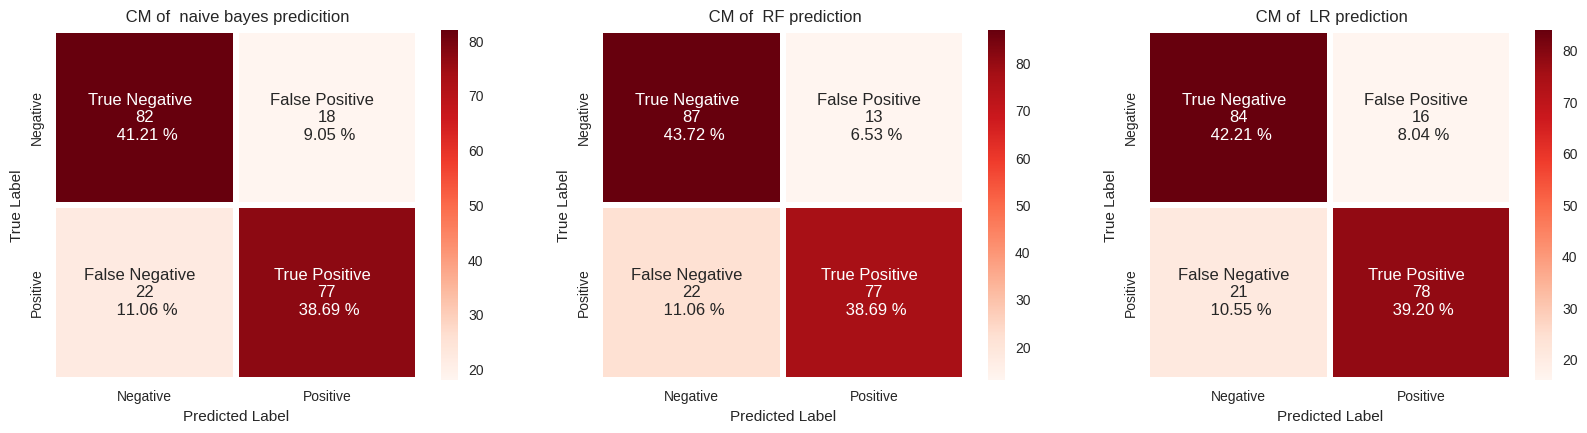

In [54]:
models_predictions=[naive_bayes_predicition,RF_prediction,LR_prediction]
model=['naive bayes predicition','RF prediction','LR prediction']
cm_names = ['True Negative' ,'False Positive','False Negative' ,'True Positive']


plt.figure(figsize=(20,10))
for i,y_pred in enumerate(models_predictions,1) :

    cm=confusion_matrix(y_test,y_pred)
    value_count = [ value  for value in cm.flatten()]
    presentage = [value for value in  cm.flatten()/ np.sum(cm)  ]
    all_labels = [f'{v1}  \n{v2}\n {v3*100:.2f} %' for v1 ,v2 ,v3 in zip(cm_names ,value_count,presentage )]
    all_labels = np.asarray(all_labels).reshape(2,2)
    plt.subplot(2,3,i)
    sns.heatmap(cm,annot=all_labels,cmap='Reds',
                linewidth=3,fmt='',xticklabels=['Negative','Positive'],
                yticklabels=['Negative','Positive']
               )


    plt.title(' CM of  '+ model[i-1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

In [55]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train = tfidf_vectorizer.fit_transform(x_train)
X_test = tfidf_vectorizer.transform(x_test)

In [56]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes =MultinomialNB()
naive_bayes.fit(X_train,y_train)

print("naive bayes Classifier training score :",naive_bayes.score(X_train,y_train))
print("naive bayes Classifier testing score :",naive_bayes.score(X_test,y_test))

naive_bayes_test_score =  round(naive_bayes.score(X_test, y_test) * 100, 2)

naive bayes Classifier training score : 0.9911949685534591
naive bayes Classifier testing score : 0.8090452261306532


In [57]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier()
RF.fit(X_train,y_train)

print("RF Classifier training score :",RF.score(X_train,y_train))
print("RF Classifier testing score :",RF.score(X_test,y_test))

RF_test_score =  round(RF.score(X_test, y_test) * 100, 2)

RF Classifier training score : 0.9987421383647799
RF Classifier testing score : 0.8090452261306532


In [58]:
from sklearn.linear_model import LogisticRegression

LR=LogisticRegression()
LR.fit(X_train,y_train)

print("LRF Classifier training score :",LR.score(X_train,y_train))
print("LR Classifier testing score :",LR.score(X_test,y_test))

lR_test_score =  round(LR.score(X_test, y_test) * 100, 2)

LRF Classifier training score : 0.9823899371069182
LR Classifier testing score : 0.8291457286432161


In [59]:
models = pd.DataFrame({
    'Model': ['Naive bayes', 'RandomForestClassifier', 'LogisticRegression'],
    'Score': [naive_bayes_test_score, RF_test_score,lR_test_score ]})

models = models.sort_values(by='Score', ascending=False)
models.style.background_gradient(cmap='Reds')

,Model,Score
2,LogisticRegression,82.910000
0,Naive bayes,80.900000
1,RandomForestClassifier,80.900000


In [60]:
fig = go.Figure(go.Funnelarea(
    text =models.Model,
    values = models.Score,
    ))

fig.update_layout(
    title='<b>Distribution of score on testing data</b>',
    titlefont={'size': 20},
    paper_bgcolor='#E0E1CD',
    plot_bgcolor='#E0E1CD',
    showlegend=False
)

fig.show()

In [61]:
naive_bayes_predicition = naive_bayes.predict(X_test)
RF_prediction = RF.predict(X_test)
LR_prediction = LR.predict(X_test)

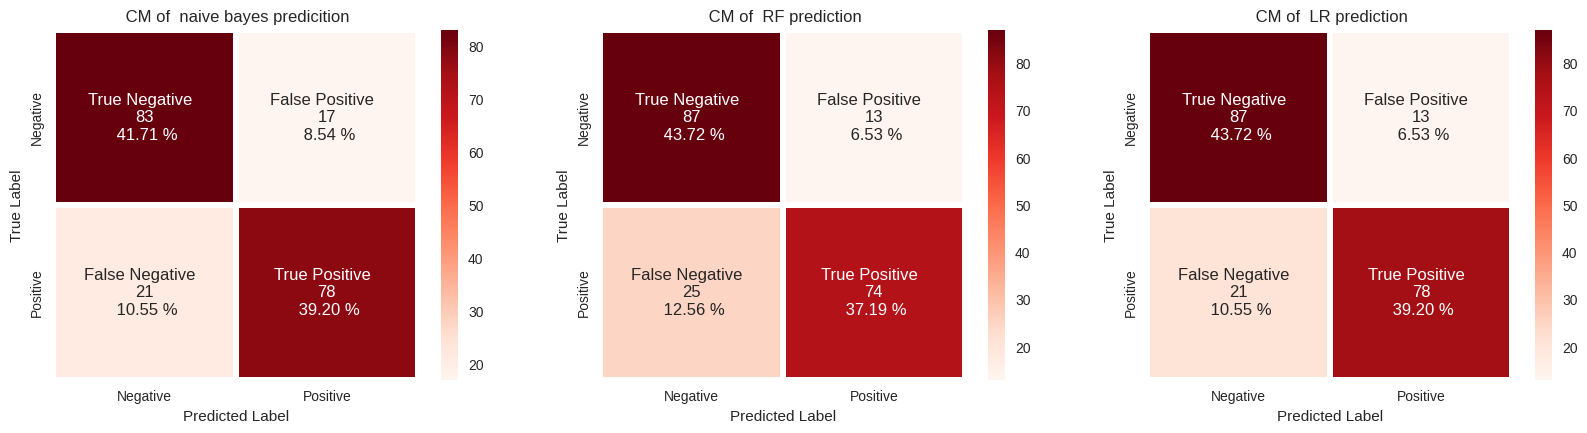

In [62]:
models_predictions=[naive_bayes_predicition,RF_prediction,LR_prediction]
model=['naive bayes predicition','RF prediction','LR prediction']
cm_names = ['True Negative' ,'False Positive','False Negative' ,'True Positive']



plt.figure(figsize=(20,10))
for i,y_pred in enumerate(models_predictions,1) :

    cm=confusion_matrix(y_test,y_pred)
    value_count = [ value  for value in cm.flatten()]
    presentage = [value for value in  cm.flatten()/ np.sum(cm)  ]
    all_labels = [f'{v1}  \n{v2}\n {v3*100:.2f} %' for v1 ,v2 ,v3 in zip(cm_names ,value_count,presentage )]
    all_labels = np.asarray(all_labels).reshape(2,2)
    plt.subplot(2,3,i)
    sns.heatmap(cm,annot=all_labels,cmap='Reds',
                linewidth=3,fmt='',
                xticklabels=['Negative','Positive'],
                yticklabels=['Negative','Positive']
               )


    plt.title(' CM of  '+ model[i-1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

In [63]:
max_len = 256
tokenizer = Tokenizer(num_words=None,oov_token='<OOV>')
tokenizer.fit_on_texts(list(x_train)+list(x_test))

X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

X_train_pad = pad_sequences(X_train_seq,maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq,maxlen=max_len)

In [64]:
word_index = tokenizer.word_index
len(word_index)

1592

VADER :-

🔘 is a pre-built sentiment analysis tool commonly used (NLP). It is designed to analyze text data and determine the sentiment polarity of the text, i.e., whether the text expresses positive, negative, or neutral sentiment.

🔘 VADER is particularly useful for sentiment analysis of social media text, short texts, and informal language, as it is specifically tuned for such contexts.

Compound Score : VADER provides a compound score that represents the overall sentiment of the text, taking into account both positive and negative language. The compound score can help in quantifying sentiment intensity.

In [67]:
vader = SentimentIntensityAnalyzer()

def sent_analysis(text):
    '''
    input : The text
    output : The sentiment of the text
    '''
    sentiment = vader.polarity_scores(text)
    compound_score = sentiment['compound']

    if compound_score > 0 :
        return 1
    else:
        return 0

In [68]:
data['vader_sent'] = data['Review'].apply(lambda x : sent_analysis(x))

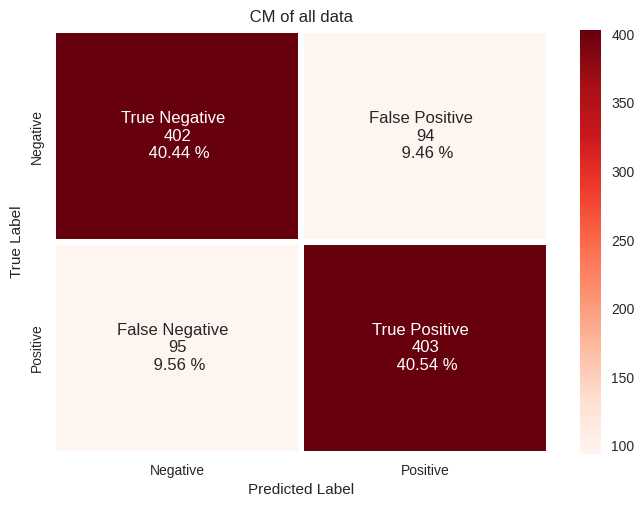

In [69]:
cm_names = ['True Negative' ,'False Positive','False Negative' ,'True Positive']
cm=confusion_matrix(data['Liked'],data['vader_sent'])
value_count = [ value  for value in cm.flatten()]
presentage = [value for value in  cm.flatten()/ np.sum(cm)  ]
all_labels = [f'{v1}  \n{v2}\n {v3*100:.2f} %' for v1 ,v2 ,v3 in zip(cm_names ,value_count,presentage )]
all_labels = np.asarray(all_labels).reshape(2,2)
sns.heatmap(cm,annot=all_labels,cmap='Reds',
                linewidth=3,fmt='',
                xticklabels=['Negative','Positive'],
                yticklabels=['Negative','Positive']
               )


plt.title(' CM of all data ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Google BERT is a powerful tool in the field of Natural Language Processing (NLP). It helps computers understand the meaning of words in a sentence by looking at the context of each word. This makes it better at understanding language and providing more accurate search results

🔘 Using BERT for sentiment analysis in restaurant reviews is a smart approach. BERT can analyze the text in these reviews and understand the nuances, such as whether customers are expressing positive or negative sentiments about their dining experience. By using BERT, you can improve the accuracy of sentiment analysis because it considers the context and subtleties of language, making it better at detecting sentiments like Positive and Negative (As in our case)

In [96]:
data

,Review,Liked,Processed_text,words_len,Review_len,vader_sent
0,Wow... Loved this place.,1,wow love place,4,24,1
1,Crust is not good.,0,crust not good,4,18,0
2,Not tasty and the texture was just nasty.,0,not tasty texture nasty,8,41,0
3,Stopped by during the late May bank holiday of...,1,stop late may bank holiday rick steve recommen...,15,87,1
4,The selection on the menu was great and so wer...,1,selection menu great price,12,59,1
...,...,...,...,...,...,...
995,I think food should have flavor and texture an...,0,think food flavor texture lack,12,66,0
996,Appetite instantly gone.,0,appetite instantly go,3,24,0
997,Overall I was not impressed and would not go b...,0,overall not impressed would not go back,10,50,0
998,"The whole experience was underwhelming, and I ...",0,whole experience underwhelme think go ninja su...,16,91,0


In [98]:
data_subset=data[['Review','Liked']]

In [99]:
data_subset.columns=["Review","Label"]

In [100]:
data_subset

,Review,Label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requi

In [2]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

data = pd.read_csv(r'Restaurant_Reviews.csv')
data.head()
data.columns=["Review","label"]

# Split into train and test sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [3]:
from transformers import AutoTokenizer,AutoTokenizer,AutoModelForSequenceClassification

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

def preprocess_function(examples):
    return tokenizer(examples["Review"], truncation=True, padding=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [4]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",  # Evaluate and save model every `eval_steps` and `save_steps`
    save_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    save_steps=500,
    eval_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=True  # Use mixed precision training if supported
)

In [5]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.4 MB/s eta 0:00:00


In [6]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)

In [7]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=150, training_loss=0.3573941548665365, metrics={'train_runtime': 23.9086, 'train_samples_per_second': 100.382, 'train_steps_per_second': 6.274, 'total_flos': 26700936206400.0, 'train_loss': 0.3573941548665365, 'epoch': 3.0})

In [8]:
# Evaluate the model
results = trainer.evaluate()
print(f"Evaluation results: {results}")

Evaluation results: {'eval_loss': 0.2552870213985443, 'eval_accuracy': 0.91, 'eval_runtime': 0.4602, 'eval_samples_per_second': 434.605, 'eval_steps_per_second': 28.249, 'epoch': 3.0}
